# Install & Import Libraroes

In [1]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 23.8 MB/s eta 0:00:00


In [2]:
import os
import re
import json
import copy
import collections

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm

from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features
import tensorflow as tf

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Download & Import Dataset

In [3]:
class PoemsDataset():

    def __init__(self, num_poems=10000, download=True):
        if download:
            !git clone https://github.com/amnghd/Persian_poems_corpus.git

        self.poets = ['moulavi', 'anvari', 'attar', 'saadi', 'bahar', 
                      'farrokhi', 'ferdousi', 'sanaee', 'jami', 'khosro']

        self.label2id = {label: i for i, label in enumerate(self.poets)}
        self.id2label = {v: k for k, v in self.label2id.items()}

        paths_origin = ['Persian_poems_corpus/original/' + poet + '.txt' for poet in self.poets]
        paths_norm = ['Persian_poems_corpus/normalized/' + poet + '_norm.txt' for poet in self.poets]
        self.path = {'origin': paths_origin, 'norm': paths_norm}

        self.x_train = []
        self.y_train = []
        self.x_val = []
        self.y_val = []
        self.x_test = []
        self.y_test = []

        self.num_poems = num_poems
        num_train = int(self.num_poems * 0.7)
        num_test = int(self.num_poems * 0.2)
        num_val = self.num_poems - num_train - num_test

        for i, poet in tqdm(enumerate(self.poets)):
            with open(self.path['norm'][i]) as f:
                for j, line in enumerate(f):
                    if j > self.num_poems:
                        break
                    if j > 1 and line != '\n':
                        if j <= num_train:
                            self.x_train.append(line)
                            self.y_train.append(self.label2id[poet])
                        elif num_train < j <= num_train + num_val:
                            self.x_val.append(line)
                            self.y_val.append(self.label2id[poet])
                        else:
                            self.x_test.append(line)
                            self.y_test.append(self.label2id[poet])

    def get_train_val_test(self):
        return self.x_train, self.y_train, self.x_val, self.y_val, self.x_test, self.y_test
    
    def count_class(self, labels):
        counter = np.zeros((len(self.poets,)))
        for i in self.label2id.values():
            counter[i] = sum(np.array(labels) == i)
        return counter

    def show_dataset_details(self):
        train_length = len(self.y_train)
        train_counter = self.count_class(self.y_train)

        val_length = len(self.y_val)
        val_counter = self.count_class(self.y_val)

        test_length = len(self.y_test)
        test_counter = self.count_class(self.y_test)

        print(f'train length = {train_length}:\t{train_counter}')
        print(f'val length = {val_length}:\t{val_counter}')
        print(f'test length = {test_length}:\t{test_counter}')

In [4]:
data = PoemsDataset(num_poems=1000)

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


10it [00:00, 929.36it/s]


In [5]:
data.show_dataset_details()

train length = 6988:	[699. 699. 699. 699. 697. 699. 699. 699. 699. 699.]
val length = 1000:	[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
test length = 2000:	[200. 200. 200. 200. 200. 200. 200. 200. 200. 200.]


In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = data.get_train_val_test()

# Prepare Data for Train

In [7]:
max_length = 128
batch_size = 64
epochs = 1
lr = 2e-5
pre_trained_model_name = 'HooshvareLab/bert-fa-base-uncased'

tokenizer = BertTokenizer.from_pretrained(pre_trained_model_name)

config = BertConfig.from_pretrained( pre_trained_model_name,
                        **{'label2id': data.label2id, 'id2label': data.id2label})

Source of the code in the cell bellow:
https://colab.research.google.com/github/hooshvare/parsbert/blob/master/notebooks/Taaghche_Sentiment_Analysis.ipynb#scrollTo=5_YqB7S7R9AK&line=10&uniqifier=1

In [8]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [9]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=max_length)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_val, y_val, maxlen=max_length)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=max_length)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=max_length, is_tf_dataset=False)

train_dataset = get_training_dataset(train_dataset_base, batch_size)
valid_dataset = get_training_dataset(valid_dataset_base, batch_size)

train_steps = len(train_examples) // batch_size
valid_steps = len(valid_examples) // batch_size

100%|██████████| 6988/6988 [00:00<00:00, 405700.00it/s]
/usr/local/lib/python3.8/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
100%|██████████| 2000/2000 [00:00<00:00, 636175.34it/s]


# Part A: Linear-Tuning

In [ ]:
linear_tuning_model = TFBertForSequenceClassification.from_pretrained(pre_trained_model_name, config=config)

linear_tuning_model.bert.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

linear_tuning_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

linear_tuning_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162,849,034
Trainable params: 7,690
Non-trainable params: 162,841,344
_________________________________________________________________


after 40 epochs:

In [ ]:
linear_tuning_model.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=train_steps,
                 validation_steps=valid_steps,epochs=10,verbose=1)

Epoch 1/10
109/109 [==============================] - 66s 606ms/step - loss: 2.2894 - accuracy: 0.1390 - val_loss: 2.2548 - val_accuracy: 0.1625
Epoch 2/10
109/109 [==============================] - 68s 623ms/step - loss: 2.2875 - accuracy: 0.1319 - val_loss: 2.2458 - val_accuracy: 0.1917
Epoch 3/10
109/109 [==============================] - 69s 630ms/step - loss: 2.2799 - accuracy: 0.1385 - val_loss: 2.2565 - val_accuracy: 0.1875
Epoch 4/10
109/109 [==============================] - 69s 630ms/step - loss: 2.2790 - accuracy: 0.1408 - val_loss: 2.2534 - val_accuracy: 0.1823
Epoch 5/10
109/109 [==============================] - 69s 629ms/step - loss: 2.2735 - accuracy: 0.1538 - val_loss: 2.2581 - val_accuracy: 0.1583
Epoch 6/10
109/109 [==============================] - 69s 631ms/step - loss: 2.2745 - accuracy: 0.1366 - val_loss: 2.2487 - val_accuracy: 0.1750
Epoch 7/10
109/109 [==============================] - 69s 632ms/step - loss: 2.2691 - accuracy: 0.1465 - val_loss: 2.2517 - val_ac

63/63 [==============================] - 16s 257ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     moulavi       0.25      0.12      0.16       200
      anvari       0.20      0.08      0.11       200
       attar       0.00      0.00      0.00       200
       saadi       0.23      0.03      0.05       200
       bahar       0.16      0.04      0.06       200
    farrokhi       0.21      0.15      0.18       200
    ferdousi       0.27      0.56      0.36       200
      sanaee       0.15      0.11      0.13       200
        jami       0.21      0.42      0.28       200
      khosro       0.16      0.51      0.24       200

    accuracy                           0.20      2000
   macro avg       0.18      0.20      0.16      2000
weighted avg       0.18      0.20      0.16      2000

Avg micro F1 score = 0.2015


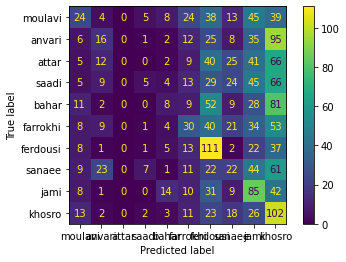

In [ ]:
predictions = linear_tuning_model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print(classification_report(ytest, ypred, target_names=data.poets))

acc = f1_score(ytest, ypred, average='micro')
print(f'Avg micro F1 score = {acc}')

cm = metrics.confusion_matrix(ytest, ypred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.poets)
disp.plot()
plt.show()

# Part B: Fine-Tuning

## Adam Opt.

In [10]:
model = TFBertForSequenceClassification.from_pretrained(pre_trained_model_name, config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162,849,034
Trainable params: 162,849,034
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=train_steps,
                 validation_steps=valid_steps,epochs=10,verbose=1)

Epoch 1/10
109/109 [==============================] - 198s 2s/step - loss: 2.0496 - accuracy: 0.2301 - val_loss: 2.5413 - val_accuracy: 0.1104
Epoch 2/10
109/109 [==============================] - 170s 2s/step - loss: 1.9525 - accuracy: 0.3023 - val_loss: 2.2031 - val_accuracy: 0.2240
Epoch 3/10
109/109 [==============================] - 170s 2s/step - loss: 1.7103 - accuracy: 0.4004 - val_loss: 2.2782 - val_accuracy: 0.2625
Epoch 4/10
109/109 [==============================] - 170s 2s/step - loss: 1.5356 - accuracy: 0.4591 - val_loss: 2.1325 - val_accuracy: 0.3000
Epoch 5/10
109/109 [==============================] - 170s 2s/step - loss: 1.2787 - accuracy: 0.5548 - val_loss: 2.1179 - val_accuracy: 0.3104
Epoch 6/10
109/109 [==============================] - 170s 2s/step - loss: 1.0579 - accuracy: 0.6203 - val_loss: 2.1091 - val_accuracy: 0.3365
Epoch 7/10
109/109 [==============================] - 170s 2s/step - loss: 0.8658 - accuracy: 0.6928 - val_loss: 2.2653 - val_accuracy: 0.3479

63/63 [==============================] - 17s 266ms/step
              precision    recall  f1-score   support

     moulavi       0.32      0.45      0.37       200
      anvari       0.24      0.57      0.34       200
       attar       0.36      0.36      0.36       200
       saadi       0.42      0.09      0.15       200
       bahar       0.25      0.14      0.18       200
    farrokhi       0.29      0.19      0.23       200
    ferdousi       0.72      0.57      0.64       200
      sanaee       0.11      0.09      0.10       200
        jami       0.41      0.33      0.36       200
      khosro       0.35      0.51      0.42       200

    accuracy                           0.33      2000
   macro avg       0.35      0.33      0.31      2000
weighted avg       0.35      0.33      0.31      2000

Avg micro F1 score = 0.3295


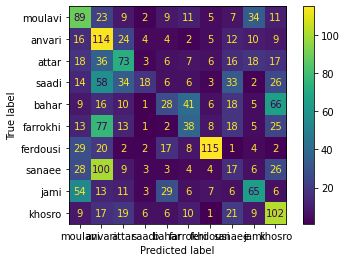

In [14]:
predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print(classification_report(ytest, ypred, target_names=data.poets))

acc = f1_score(ytest, ypred, average='micro')
print(f'Avg micro F1 score = {acc}')

cm = metrics.confusion_matrix(ytest, ypred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.poets)
disp.plot()
plt.show()

## SGD Opt.

In [15]:
model = TFBertForSequenceClassification.from_pretrained(pre_trained_model_name, config=config)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162841344 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162,849,034
Trainable params: 162,849,034
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=train_steps,
                 validation_steps=valid_steps,epochs=10,verbose=1)

Epoch 1/10
109/109 [==============================] - 167s 2s/step - loss: 2.3170 - accuracy: 0.1260 - val_loss: 2.3069 - val_accuracy: 0.0990
Epoch 2/10
109/109 [==============================] - 166s 2s/step - loss: 2.3356 - accuracy: 0.0940 - val_loss: 2.2988 - val_accuracy: 0.1125
Epoch 3/10
109/109 [==============================] - 166s 2s/step - loss: 2.3232 - accuracy: 0.0996 - val_loss: 2.3048 - val_accuracy: 0.0938
Epoch 4/10
109/109 [==============================] - 166s 2s/step - loss: 2.3207 - accuracy: 0.1046 - val_loss: 2.3070 - val_accuracy: 0.1000
Epoch 5/10
109/109 [==============================] - 166s 2s/step - loss: 2.3185 - accuracy: 0.0996 - val_loss: 2.3020 - val_accuracy: 0.1198
Epoch 6/10
109/109 [==============================] - 166s 2s/step - loss: 2.3127 - accuracy: 0.1088 - val_loss: 2.2992 - val_accuracy: 0.1021
Epoch 7/10
109/109 [==============================] - 166s 2s/step - loss: 2.3077 - accuracy: 0.1184 - val_loss: 2.2990 - val_accuracy: 0.1042

63/63 [==============================] - 18s 276ms/step
              precision    recall  f1-score   support

     moulavi       0.14      0.09      0.11       200
      anvari       0.24      0.12      0.16       200
       attar       0.10      0.01      0.03       200
       saadi       0.35      0.04      0.06       200
       bahar       0.09      0.04      0.06       200
    farrokhi       0.11      0.12      0.11       200
    ferdousi       0.21      0.28      0.24       200
      sanaee       0.09      0.14      0.11       200
        jami       0.18      0.41      0.26       200
      khosro       0.14      0.24      0.18       200

    accuracy                           0.15      2000
   macro avg       0.17      0.15      0.13      2000
weighted avg       0.17      0.15      0.13      2000

Avg micro F1 score = 0.151


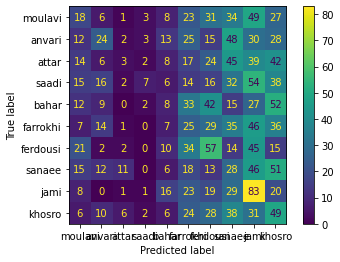

In [19]:
predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()

print(classification_report(ytest, ypred, target_names=data.poets))

acc = f1_score(ytest, ypred, average='micro')
print(f'Avg micro F1 score = {acc}')

cm = metrics.confusion_matrix(ytest, ypred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data.poets)
disp.plot()
plt.show()